In [3]:
import pandas as pd
import numpy as np
import csv
import json
import mysql.connector

## Instrucciones
* La base de datos utilizada será MySQL.
* para usar una base de datos se necesitan las credenciales, las cuales deben estar almacenadas en un archivo "credentials.json" que debe estar en el mismo directorio desde que ejecuta este .ipynb
* por temas de seguridad, NO enviaré mi archivo credentials.json con mis credenciales. Para la ejecución de este codigo hay que crearlo desde cero. Los valores este archivo json deben ser:
    - "host": el servidor ("localhost", en caso de ser local)
    - "user": el nombre de usuario
    - "password": la contraseña
    - "database": el nombre de la base de datos

### Parte 1: Ingreso de información a base de datos
* De las instrucciones se asume que no se puede trabajar directamente desde el archivo .csv provisto y que es necesario ingresar su información a una base de datos
* En esta sección se creará una base de datos y se ingresarán los viajes
* La base de datos utilizada será MySQL.
* para usar una base de datos se necesitan las credenciales, las cuales deben estar almacenadas en un archivo "credentials.json" que debe estar en el mismo directorio desde que ejecuta este .ipynb
* las propiedades del json deben estar en formato string con doble comillas (por ejemplo, "user":"root")



In [21]:

credentials = json.load(open("credentials.json"))


db_conn = mysql.connector.connect(
    host = credentials['host'],
    user = credentials['user'],
    password = credentials['password'],
    database = credentials['database']
)

if db_conn.is_connected():
    print('base de datos conectada')

base de datos conectada


In [22]:
'''
A continuación, se guardará la información de trips.csv en la base de datos
primero, se crea la tabla viajes
'''
if db_conn.is_connected():
    cursor = db_conn.cursor()

    table_name = 'viajes'
    cursor.execute(f'DROP TABLE IF EXISTS {table_name};')#se crea la tabla si es que no existe
    print(f'creando tabla "{table_name}"')
    table_cols = [
        {
            'col_name':'region',
            'col_type':'varchar(30)' #se que solo son 3 regiones, pero en el caso de que se agreguen más hay que considerar la posibilidad en que estas tengan nombres largos  
        },
        {
            'col_name':'origin_coordX',
            'col_type':'decimal(16,14)'
        },
        {
            'col_name':'origin_coordY',
            'col_type':'decimal(16,14)'
        },
        {
            'col_name':'destination_coordX',
            'col_type':'decimal(16,14)'
        },
        {
            'col_name':'destination_coordY',
            'col_type':'decimal(16,14)'
        },
        {
            'col_name':'datetime',
            'col_type':'datetime'
        },
        {
            'col_name':'datasource',
            'col_type':'varchar(30)'
        },
    ]
    query = f"CREATE TABLE {table_name} ("
    for col in table_cols:#agrego a la consulta cada columna
        query += f"{col['col_name']} {col['col_type']},"
    query = query[:-1]#le saco la coma del final, que sobra
    query += ")"

    cursor.execute(query)
    print(f'tabla "{table_name}" creada')


creando tabla "viajes"
tabla "viajes" creada


In [23]:
'''
luego, se agregan los elementos del .csv en la base de datos
'''
trips_df = pd.read_csv("trips.csv")#leo la información de los viajes
if db_conn.is_connected():
    table_name = "viajes"
    cursor = db_conn.cursor()
    print(f"insertando filas en tabla {table_name}")
    #itero sobre cada fila
    for index, row in list(trips_df.iterrows()):

        origin = row['origin_coord'].split(" ") #["POINT", "(12.3456...", "12.3456)"]
        originX = origin[1][1:] # coordenada X del origen. Le saco el "(" del principio al string y casteo como flotante
        originY = origin[2][:-1] # coordenada Y del origen. le saco el ")" del final al string y casteo como flotante

        dest = row['destination_coord'].split(" ") #["POINT", "(12.3456...", "12.3456)"]
        destX = dest[1][1:] # coordenada X del destino. Le saco el "(" del principio al string y casteo como flotante
        destY = dest[2][:-1] # coordenada Y del destino. le saco el ")" del final al string y casteo como flotante

        travel_data = {
            'region':f'"{row["region"]}"',#valores de tipo string deben estar con doble comillas, para la creación del query
            'origin_coordX':originX,
            'origin_coordY':originY,
            'destination_coordX':destX,
            'destination_coordY':destY,
            'datetime':f'"{row["datetime"]}"',
            'datasource':f'"{row["datasource"]}"'
        }
        #ahora creo la query del viaje
        query = f'INSERT INTO {table_name} ({", ".join(travel_data.keys())}) VALUES ({", ".join(travel_data.values())});'
        cursor.execute(query)
        db_conn.commit()
    
    print("filas insertadas")



insertando filas en tabla viajes
filas insertadas


### Parte 2: Obtención de datos desde la base de datos
Luego de que la base de datos está creada, se sacan los datos desde acá

In [24]:
travel_data = []
if db_conn.is_connected():
    cursor = db_conn.cursor()
    table_name = 'viajes'
    query = f'SELECT * FROM {table_name}'
    cursor.execute(query)
    travel_data = cursor.fetchall()

A continuación se realizará una estimación de cuanto pesarían los datos esto en el caso de que el número de entradas sea igual a 100 millones (de acuerdo a la condición de la escalabilidad explicitada en el readme)

In [25]:
import sys
data_size = sys.getsizeof(travel_data)
data_len = len(travel_data)
hypothetical_size = 1000000000 * data_size / data_len
print(hypothetical_size)

9040000000.0


Los datos pesan aproximadamente 9 mil millones de bytes o 9 gigabytes. Un computador "comerical" con buena RAM puede almacenar esta cantidad de datos para ejecución, pero hay que tener cuidado con la manipulación de datos y los ordenes de peso en los siguientes algoritmos.

### Parte 3: Visualización previa
En primer lugar, visualizaremos las trayectorias de los viajes. En primer lugar mostraremos los viajes realizados en las 3 regiones al mismo tiempo.


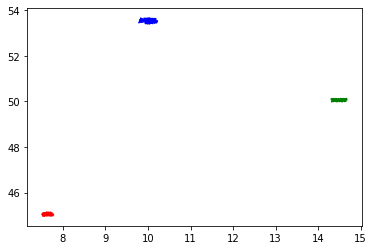

In [26]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, ax = plt.subplots()

for travel in travel_data:
    region, originX, originY, destX, destY, datetime, datasource = travel
    color = "y"
    if region == "Prague":
        color = "g"
    elif region == "Turin":
        color = "r"
    elif region == "Hamburg":
        color = "b"
    ax.plot([originX,destX],[originY,destY], color)
    



Ahora, mostraremos los viajes en cada región especificada. Los desitnos se marcan con una X.

In [27]:
def show_region_travels(selected_region):
    fig, ax = plt.subplots()
    for travel in travel_data:
        region, originX, originY, destX, destY, datetime, datasource = travel
        if region == selected_region:
            ax.plot([originX,destX],[originY,destY],color="b")
            ax.scatter(destX,destY, marker="x",color="b")
            #ax.scatter((originX+destX)/2, (originY+destY)/2, marker="o", color="r")



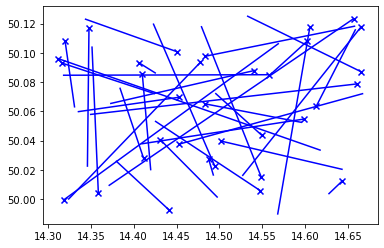

In [28]:
show_region_travels("Prague")

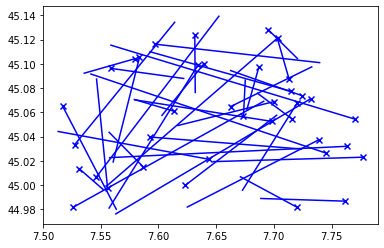

In [29]:
show_region_travels("Turin")

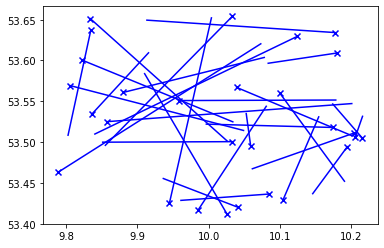

In [30]:
show_region_travels("Hamburg")

En conlusión, debido a la distancia entre las regiones, dos viajes "similares" siempre estarán en la misma región.

### Parte 4: Preprocesamiento y solución en base a clustering

La solución se realizará mediante clustering, es decir, juntar grupos de viajes que se asemejen en 5 dimensiones:
1. Coordenada X de partida
2. Coordenada Y de partida
3. Coordenada X de llegada
4. Coordenada Y de llegada
5. hora (se considerará solo la hora, no la fecha)

Cada grupo consistirá en viajes en una misma región, por lo que se tendrá que hacer una separación de los viajes por regiones.

Para que la solución sea escalable, se separarán directamente los datos por regiones desde la base de datos (ASUMIENDO QUE SOLO EXISTEN VIAJES DE ESAS TRES REGIONES). Para que se cumpla la escalabilidad en el caso de los 100 millones de ejemplos, se debe ignorar el código de la parte 2.

Al trabajar en regiones separadas, y asumiendo que cada región aportará un tercio de los viajes en el conjunto de los 100 millones de ejemplos, se podría trabajar separadamente con un tercio de los viajes. Esto quere decir que en vez de 9 gygabites, se puede trabajar 3 gygabites.

Esta vez se seleccionará para cada viaje (separado por región) solo las coordenadas de origen y destino; y la hora.

In [104]:
travel_Prague = []
travel_Turin = []
travel_Hamburg = []

if db_conn.is_connected():
    cursor = db_conn.cursor()
    table_name = 'viajes'
    query = f'SELECT origin_coordX, origin_coordY, destination_coordX, destination_coordY, HOUR(datetime) FROM {table_name} where region="Prague"'
    cursor.execute(query)
    travel_Prague = cursor.fetchall()
    
    query = f'SELECT origin_coordX, origin_coordY, destination_coordX, destination_coordY, HOUR(datetime) FROM {table_name} where region="Turin"'
    cursor.execute(query)
    travel_Turin = cursor.fetchall()
    
    query = f'SELECT origin_coordX, origin_coordY, destination_coordX, destination_coordY, HOUR(datetime) FROM {table_name} where region="Hamburg"'
    cursor.execute(query)
    travel_Hamburg = cursor.fetchall()
    

Para reducir la cantidad de dimensiones de los datos (actualmente 5) se tomará la coordenada de la mitad de cada viaje en lugar de las coordenadas de origen y destino de viaje. Esta coordenada se calcula de la siguiente forma:

$$
\text{coordenada del centro centro}: (\frac{origenX+destinoX}{2},\frac{origenY+destinoY}{2})
$$

Queda como ejercicio probar como se comportará la solución propuesta sin hacer esta transformación, pues ésta podría estar comprometiendo la representatividad de los resultados finales. De todas formas, ahora que hay 2 dimensiones para representar las coordenadas espaciales de los viajes en lugar de 4, la dimensión correspondiente al horario cobra más importancia.

De esta forma, en lugar de 5 dimensiones ahora se puede trabajar con 3: coordenada X de la mitad del viaje, coordenada Y de la mitad del viaje y hora (además de facilitar los procesos en cuanto a tiempo, también requiere mucho menos espacio).

Los algoritmos de clustering se basan en las diferencias calculadas entre los ejemplos que se tienen. Uno de los datos de cada viaje es la hora, la cual varía de "0" (12AM) a 23:00 (11PM). El problema es que si se ocupa este formato, la diferencia en cuanto a tiempo entre un viaje que empieza a las 23 horas y uno que empieza a las 0 horas es de 23 horas (cuando en realidad la diferencia es de una hora). Por lo tanto, hay que también pasar la hora a un formato tipo coseno, de la siguiente forma:

$$
\text{hora cosenoidal(hora)}=cos(\frac{2*hora*\pi}{24})=cos(\frac{hora*\pi}{12})
$$

De esta forma, la diferencia entre la hora 23 y la hora 0, o la hora 20 y la hora 4 (por ejemplo) podrá ser minima aunque haya pasado el día.

In [106]:
import math

def cos_hour(x):
    return math.cos(x*math.pi/12)

def transform_travel_data(travel_data, region):
    print(f"transformando datos para región: {region}")
    L = len(travel_data)
    travel_transformed = []#originalmente iba a transformar la lista travel data para ahorrar espaciom pero necesitaré las coordenadas originales para una futura visualización
    for i in range(L):
        if i%5 == 0:
            print(f"{100.0*i/L:.2f}%")
        travel = travel_data[i]
        originX, originY, destX, destY, hour = travel
        centerX = (float(originX)+float(destX))/2
        centerY = (float(originY)+float(destY))/2
        cosine_hour = cos_hour(hour)
        
        #travel_data[i] = centerX, centerY, cosine_hour
        travel_transformed.append( (centerX, centerY, cosine_hour) )
        
    print("100%")
    
    return travel_transformed

travel_Prague_trans = transform_travel_data(travel_Prague,"Prague")
travel_Turin_trans = transform_travel_data(travel_Turin,"Turin")
travel_Hamburg_trans = transform_travel_data(travel_Hamburg,"Hamburg")

transformando datos para región: Prague
0.00%
14.71%
29.41%
44.12%
58.82%
73.53%
88.24%
100%
transformando datos para región: Turin
0.00%
13.16%
26.32%
39.47%
52.63%
65.79%
78.95%
92.11%
100%
transformando datos para región: Hamburg
0.00%
17.86%
35.71%
53.57%
71.43%
89.29%
100%


También normalizaremos cada los elementos en cada dimensión para que los valores estén entre 0 y 1.

In [107]:
def normalize(travel_data, region):
    print(f"normalizando para region: {region}")
    
    Xmin = 999999999999
    Xmax = -99999999999
    Ymin = 999999999999
    Ymax = -9999999999
    
    for travel in travel_data:
        #print(travel)
        centerX, centerY, cos_hour = travel
        if centerX < Xmin:
            Xmin = centerX
        if centerX > Xmax:
            Xmax = centerX
        if centerY < Ymin:
            Ymin = centerY
        if centerY > Ymax:
            Ymax = centerY
    
    L = len(travel_data)
    for i in range(L):
        if i%5 == 0:
            print(f"{100.0*i/L:.2f}%")

        centerX, centerY, cosine_hour = travel_data[i]
        #normalizo ocumando la formula (X-Xmax)/(Xmax-Xmin)
        normX = (centerX - Xmin)/(Xmax-Xmin)
        normY = (centerY - Ymin)/(Ymax-Ymin)
        
        travel_data[i] = normX, normY, (cosine_hour+1)/2 # lo ultimo se hace para pasar cosine_hour del rango [-1,1] al rango [0,1]
    print("100%")  
    return travel_data
            
travel_Prague_trans = normalize(travel_Prague_trans, "Prague")
travel_Turin_trans = normalize(travel_Turin_trans, "Turin")
travel_Hamburg_trans = normalize(travel_Hamburg_trans, "Hamburg")

normalizando para region: Prague
0.00%
14.71%
29.41%
44.12%
58.82%
73.53%
88.24%
100%
normalizando para region: Turin
0.00%
13.16%
26.32%
39.47%
52.63%
65.79%
78.95%
92.11%
100%
normalizando para region: Hamburg
0.00%
17.86%
35.71%
53.57%
71.43%
89.29%
100%


Una vez reducida la dimensionalidad y normalizados los datos, se puede pasar al algoritmo de clustering. Para este caso se opta por utilizar el algoritmo k-means. En resumen, este algoritmo consiste en los siguientes pasos:
   1. Elegir K ejemplos aleatorios (en este caso viajes), donde K es el número de grupos que buscamos (K es un parámetro ajustable). Estos puntos serán los "centroides" de cada grupo. (tiempo: $O(1)$, espacio: $O(N)$, donde N es la cantidad de ejemplos)
   2. Para cada ejemplo que no es un centroide, se le asigna al grupo de su centroide más cercano según una formula de distancia (tiempo: $O(N*K)$, espacio: $O(N)$)
   3. Una vez se hayan asignado todos los ejemplos a un grupo, para cada grupo se calcula su "punto promedio" (el promedio de todos sus ejemplos). Estos puntos serán los nuevos centroides. (tiempo: $O(N)$, espacio: $O(N)$ (depende del tamaño de los grupos, pero este escala con N))
   4. Volver al paso 2 y repetir un total de "I" veces (donde I es un parámetro) o hasta llegar a una convergencia. 
   5. Se puede repetir todo "E" (donde E también es un parámetro) veces, eligiendo la configuración de grupos en que la suma de variaciones de distancias cada grupo sea minima.
   
En total, k-means tiene un coste de un orden de magnitud de $O(N*K*I*E)$ en cuanto a tiempo y O(N) en cuanto a espacio. Considerando que K, I y E no tienen que ser valores no muy grandes, el algoritmo es escalable.
   
En este caso la formula de distancia será euclidiana. Si cada viaje consta de:
* CenterX: coordenada X normalizada de la mitad del viaje
* CenterY: coordenada Y normalizada de la mitad del viaje
* cosHora: hora transformada en formato cosenoidal  

Entonces la distancia entre dos viajes se calcula como:
$$
distancia(viaje_1, viaje_2) = \sqrt{(CenterX_1 - centerX_2)^2 + (centerY_1 - centerY_2)^2 + (cosHora_1 - cosHora_2)^2}
$$
   
Por temas de comodidad se usará la librería sklearn para esta tarea. 


In [108]:
from sklearn.cluster import KMeans

'''
recibe travel_data, una lista de viajes en formato (centroX, centroY, cosHora)
devuelve una lista de enteros de largo |travel_data|. Estos valores van de 0 a K-1 e indican a que cluster se asigna cada elemento de travel_data.
'''
def kmeans(travel_data, K=5, I=75, E=15):
    
    km = KMeans(
        n_clusters = K,
        init = 'random',
        n_init = E,
        max_iter = I
    )
    
    groups = km.fit_predict(travel_data)
    return groups

Para este caso se usará $I=75$ y E=$15$ (queda como ejecricio propuesto experimentar con estos valores). Con respecto a K, se tendrá que elegir el numero de "clusters" o grupos. Para hacer esto se puede usar el método "elbow", que consiste en probar con muchos valores de K e ir analizando el desempeño según la métrica "SSE", que consiste en las suma de las distancias cuadráticas entre cada valor y el centroide de su grupo. La formula es la siguiente:

$$
SSE = \sum^{K}_{k=0}\sum_{x \in C_{k}}distancia(c_{k}, x)^{2}
$$

(donde $C_{k}$ es el cluster $k$ y $c_{k}$ es su correspondiente centroide)

En sklearn, este valor se obtiene directamente de la variable "inertia_". Para las tres regiones se analizará el resultado usando valores de $K$ del $3$ al $10$.

In [109]:
#se quiere graficar el SSE obtenido para valores de K del 3 al 10 aplicados a data
def plot_elbow(data, I=75, E=15):
    SSE_list = []
    for K in range(3,11):
        print(f"calculando con K={K}")
        km = KMeans(
            n_clusters = K,
            init = 'random',
            n_init = E,
            max_iter = I
        )
        km.fit(data)
        SSE_list.append(km.inertia_)
        
    plt.plot(range(3, 11), SSE_list, marker='o')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.show()


calculando con K=3
calculando con K=4
calculando con K=5
calculando con K=6
calculando con K=7
calculando con K=8
calculando con K=9
calculando con K=10


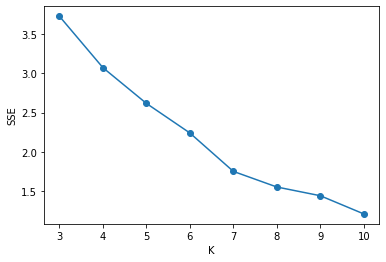

In [110]:
plot_elbow(travel_Prague_trans)

calculando con K=3
calculando con K=4
calculando con K=5
calculando con K=6
calculando con K=7
calculando con K=8
calculando con K=9
calculando con K=10


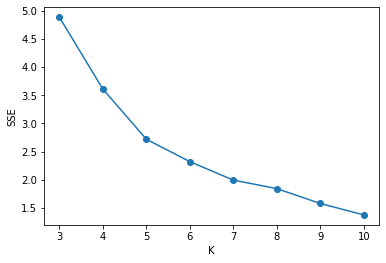

In [111]:
plot_elbow(travel_Turin_trans)

calculando con K=3
calculando con K=4
calculando con K=5
calculando con K=6
calculando con K=7
calculando con K=8
calculando con K=9
calculando con K=10


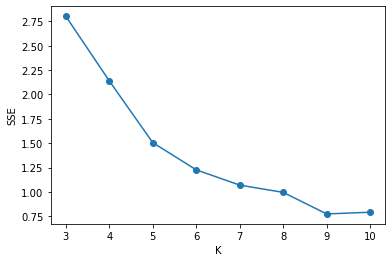

In [112]:
plot_elbow(travel_Hamburg_trans)

El truco de "elbow" es elegir el valor de $K$ en que la curva presente un "codo". Acá se busca un valor de $K$ suficientemente bajo en el que se alcance un SSE suficientemente bajo . En este ejercicio no se especifica que el numero de grupos debe ser bajo, pero asumamos que no quieremos que sea un número excesivamente alto.

* Para Prague, se escoge $K=6$.
* Para Turin, se escoge $K=5$.
* Para Hamburg, se escoge $K=5$

NOTA: esto podría variar en el caso de los 100 millones de ejemplos. 

Dando un total de 16 grupos. Por lo tanto, los grupos se obtienen así:

In [113]:
groups_Prague = kmeans(travel_Prague, 6)

In [114]:
groups_Turin = kmeans(travel_Turin, 5)

In [115]:
groups_Hamburg = kmeans(travel_Hamburg, 5)

Considerando cada configuración de grupos correspondiente a cada región es un arreglo con valores de $0$ a $K-1$, para que no se repitan valores al considerar a las tres regiones juntas, se realizará la siguiente transformación.

In [116]:
for i in range(len(groups_Turin)):
    groups_Turin[i]+=6 #el valor maximo encontrado en los grupos de la región Prague es 5, mas uno es 6.
    #de este modo, los grupos asignados para Turin estarán representados por valores del 6 al 11.
    
for i in range(len(groups_Hamburg)):
    groups_Hamburg[i]+=11 #el valor maximo encontrado en los grupos de la región Turin es 11 (dada la transformación anterior), mas uno es 12.
    #de este modo, los grupos asignados para Hamburg estarán representados por valores del 12 al 16
    

In [117]:
groups_Prague#grupos 0-5

array([2, 2, 1, 5, 5, 3, 0, 0, 5, 0, 5, 3, 1, 5, 0, 1, 1, 0, 0, 3, 1, 4,
       4, 2, 1, 3, 1, 0, 2, 0, 2, 4, 2, 3])

In [118]:
groups_Turin#grupos 6-10

array([ 8, 10, 10,  8,  8,  7,  6,  6,  6, 10, 10,  7,  7,  6,  6, 10,  6,
        9,  7,  6,  7,  9,  9,  7, 10, 10, 10,  7,  7,  7,  7,  6,  8,  6,
        7,  9,  7,  9])

In [119]:
groups_Hamburg#grupos 11-16

array([15, 15, 13, 11, 15, 12, 15, 11, 15, 14, 15, 15, 11, 13, 14, 15, 15,
       11, 12, 11, 12, 11, 14, 11, 11, 12, 15, 15])

### Parte 5: Promedio semanal

Finalmente se calculará el promedio semanal por grupo.

In [130]:
travel_Prague_weeks = []
travel_Turin_weeks = []
travel_Hamburg_weeks = []

#esta vez obtengo las semanas usando la función WEEK de MYSQL. Ojo que cada semana obtenida es correspondiente a cada elemento de las listas groups_Prague, groups_Turin y groups_Hamburg. Es decir, se devuelven las semanas de cada viajes en el mismo orden. 
if db_conn.is_connected():
    cursor = db_conn.cursor()
    table_name = 'viajes'
    query = f'SELECT WEEK(datetime) FROM {table_name} where region="Prague"'
    cursor.execute(query)
    travel_Prague_weeks = cursor.fetchall()
    
    query = f'SELECT WEEK(datetime) FROM {table_name} where region="Turin"'
    cursor.execute(query)
    travel_Turin_weeks = cursor.fetchall()
    
    query = f'SELECT WEEK(datetime) FROM {table_name} where region="Hamburg"'
    cursor.execute(query)
    travel_Hamburg_weeks = cursor.fetchall()
    

In [129]:
def week_mean(weeks, groups, region):#entrega el promedio semanal de numero de viajes por grupos
    print(f"calculando promedio semanal para grupos de la región: {region}")
    data = {}#acá almacenará el numero de viajes por cada grupo y por cada semana. 
    #Cada elemento del diccionario será de la forma {"grupo": {semana1: cantsemana1, semana2: cant:semana2, etc}}

    for week, group in zip(weeks, groups):#itero en las dos listas al mismo tiempo
        
        if group not in data: #si el grupo no se ha agregado al diccionario, se debe inicializar como un diccionario vacío
            data[group] = {}
            
        #ahora, veo la semana
        if week not in data[group]: #si no he guardado la semana para el grupo (que es un diccionario), la inicializo con cantidad de apariciones = 1
            data[group][week] = 1
        else:
            data[group][week] += 1 #si ya se ha guardado la semana para este grupo, le sumo una aparación
            

    #ya almacenadas la cantidad de viajes por semana y por grupo, saco el promedio semanal

    for group, week_aparitions in data.items():
        aparitions = list(week_aparitions.values()) # lista con las cantidades semanales de un grupo
        mean = np.array(aparitions).mean()
        data[group] = mean #reemplazo el diccionario con apariciones semanales por los datos
        
        print(f"grupo {group} tiene {mean} viajes semanales en promedio")
            
    return
            
        

In [88]:
print("región: Prague")
week_mean(travel_Prague_weeks, groups_Prague)

región: Prague
grupo 1 tiene 1.5 viajes semanales en promedio
grupo 5 tiene 1.2 viajes semanales en promedio
grupo 4 tiene 2.5 viajes semanales en promedio
grupo 2 tiene 1.4 viajes semanales en promedio
grupo 3 tiene 1.3333333333333333 viajes semanales en promedio
grupo 0 tiene 2.0 viajes semanales en promedio


In [89]:
print("region: Turin")
week_mean(travel_Turin_weeks, groups_Turin)

region: Turin
grupo 7 tiene 2.0 viajes semanales en promedio
grupo 9 tiene 2.0 viajes semanales en promedio
grupo 10 tiene 1.5 viajes semanales en promedio
grupo 11 tiene 1.75 viajes semanales en promedio
grupo 8 tiene 1.5 viajes semanales en promedio
grupo 6 tiene 1.25 viajes semanales en promedio


In [90]:
print("region: Hamburg")
week_mean(travel_Hamburg_weeks, groups_Hamburg)

region: Hamburg
grupo 13 tiene 1.6666666666666667 viajes semanales en promedio
grupo 15 tiene 1.25 viajes semanales en promedio
grupo 14 tiene 1.2 viajes semanales en promedio
grupo 16 tiene 1.2 viajes semanales en promedio
grupo 12 tiene 2.0 viajes semanales en promedio
